# Shallow Convolutional Neural Network

Author: Akhil Punia

Date: 11.24.19

**Completed:**

1.   Build Basic CNN Architecture
2.   Set Train, Test & Valid Routine
3.   Reweigh Loss Function for Class Imabalance
4.   Normalize Images
5.   He Weight Initialisation & Adam Optimizer
6.   Confusion Matrix

**TO DO:**

1.   Log Train, Test Error to Tensorboard  
2.   Log PR Curve to Tensorboard
3.   Plot Class Activation Maps
4.   Use Learning Rate Scheduler for setting  Cyclical Learning Rate [link](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.CyclicLR)




## Setting up the Environment


In [0]:
import torch
import torchvision

import numpy as np 
from torchvision import transforms, datasets

## Preparing the Dataset


In [0]:
! wget -q 'https://storage.googleapis.com/capstone-fs7/img_patches_128_c8.zip'
! unzip -q '/content/img_patches_128_c8.zip' 

In [7]:
n_epochs = 10
log_interval = 20

data_dir='/content/img_patches_128_c8'
train_dir = data_dir + '/serial-train'
valid_dir = data_dir + '/serial-val'
test_dir = data_dir + '/control'

batch_size_train = 64
batch_size_valid = 4103
batch_size_test = 3655

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

For repeatable experiments we have to set random seeds for anything using random number generation - this means `numpy` and `random` as well! It's also worth mentioning that cuDNN uses nondeterministic algorithms which can be disabled setting `torch.backends.cudnn.enabled = False`.


In [0]:
# scale the image down by it's global mean and std. deviation
# https://discuss.pytorch.org/t/about-normalization-using-pre-trained-vgg16-networks/23560/6

def mean_std(dir, batch_size):
  dataset = datasets.ImageFolder(dir, transform=transforms.Compose([transforms.ToTensor()]))

  loader = torch.utils.data.DataLoader(dataset,
                                      batch_size=batch_size,
                                      num_workers=1,
                                      shuffle=False)

  mean = 0.
  std = 0.

  nb_samples = 0.
  for data, target in loader:

    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

  mean /= nb_samples
  std /= nb_samples
  print(dir+':: \n Mean: ', mean, '\t Std: ', std )

  mean = list(mean.numpy())
  std = list(std.numpy())
  return mean, std

In [9]:
mean_tr, std_tr = mean_std(train_dir, batch_size_train)
mean_va, std_va = mean_std(valid_dir, batch_size_valid)
mean_te, std_te = mean_std(test_dir, batch_size_test)

/content/img_patches_128_c8/serial-train:: 
 Mean:  tensor([0.6451, 0.6023, 0.5343]) 	 Std:  tensor([0.1896, 0.2028, 0.2194])
/content/img_patches_128_c8/serial-val:: 
 Mean:  tensor([0.6464, 0.6044, 0.5355]) 	 Std:  tensor([0.1910, 0.2037, 0.2205])
/content/img_patches_128_c8/control:: 
 Mean:  tensor([0.5786, 0.5341, 0.4629]) 	 Std:  tensor([0.1486, 0.1513, 0.1590])


Now we'll also need DataLoaders for the dataset. This is where TorchVision comes into play. It let's use load the dataset in a handy way. We'll use a `batch_size` of 64 for **training** and size `867` for **testing** on this dataset. 

The values `[0.6453, 0.6027, 0.5345]` and `[0.1899, 0.2030, 0.2196]` used for the `Normalize()` transformation below are the global mean and standard deviation of the dataset, we'll take them as a given here.

TorchVision offers a lot of handy transformations, such as cropping or normalization.

In [0]:
# 2.1 Define transforms for the training, validation, and testing sets

train_transforms = transforms.Compose([#transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean_tr,
                                                            std_tr)])

valid_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean_va, 
                                                            std_va)])

test_transforms  = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean_te,
                                                            std_te)])

# 2.2 Load the datasets with ImageFolder

train_dataset = datasets.ImageFolder(train_dir, 
                                     transform=train_transforms)

valid_dataset = datasets.ImageFolder(valid_dir, 
                                     transform=valid_transforms)

test_dataset  = datasets.ImageFolder(test_dir, 
                                     transform=test_transforms)

# 2.3 Using the image datasets and the transforms, define the dataloaders

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size_train, 
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size=batch_size_valid)

test_loader  = torch.utils.data.DataLoader(test_dataset, 
                                           batch_size=batch_size_test,
                                           shuffle=True)

In [0]:
# train_dataset : 3808
# valid_dataset : 956
# test_dataset : 867

PyTorch's `DataLoader` contain a few interesting options other than the dataset and batch size. For example we could use `num_workers > 1` to use subprocesses to asynchronously load data or using pinned RAM (via `pin_memory`) to speed up RAM to GPU transfers. But since these mostly matter when we're using a GPU we can omit them here.

Now let's take a look at some examples. We'll use the `test_loader` for this.

In [0]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

Ok let's see what one test data batch consists of.

In [13]:
example_data.shape

torch.Size([867, 3, 128, 128])

In [0]:
# https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/3

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [0]:
unorm = UnNormalize(mean=mean_te, std=std_te)

In [0]:
# https://stackoverflow.com/questions/42014545/how-to-change-numpy-array-from-128-128-3-to-3-128-128

def disp_image(arr):
  arr = unorm(arr) # unnormalize
  arr = arr.numpy()
  return(np.swapaxes(arr, 2,0))

So one test data batch is a  tensor of shape: `torch.Size([867, 3, 128, 128])` . This means we have 867 examples of 128x128 pixels (i.e. rgb channels, hence three). We can plot some of them using matplotlib.

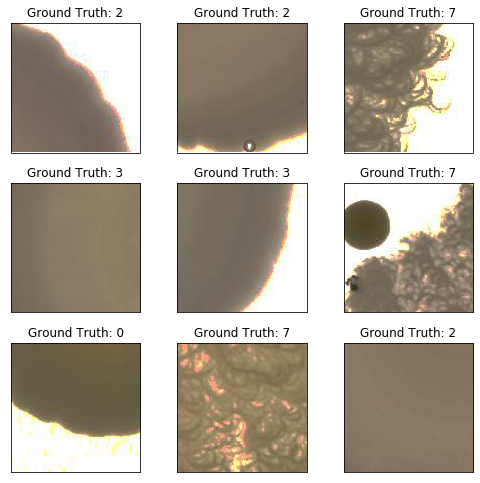

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,7))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(disp_image(example_data[i]), interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])


## Building the Network

Now let's go ahead and build our network. We'll use two 2-D convolutional layers followed by two fully-connected (or linear) layers. As activation function we'll choose rectified linear units (ReLUs in short) and as a means of regularization we'll use two dropout layers. In PyTorch a nice way to build a network is by creating a new class for the network we wish to build. Let's import a few submodules here for more readable code.

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
# https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-he-init.ipynb

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        # 128x128x3 => 128x128x6
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=6, 
                               kernel_size=5,
                               padding= 2) # p = (1(128-1) - 128 + 5)/2 = 2

        # 64x64x6 => 64x64x12
        self.conv2 = nn.Conv2d(in_channels=6, 
                               out_channels=12, 
                               kernel_size=5,
                               padding= 2) # p = (1(64-1) - 64 + 5)/2 = 2
        self.conv2_drop = nn.Dropout2d()

        # 32x32x12 => 32x32x16
        self.conv3 = nn.Conv2d(in_channels=12, 
                               out_channels=12, 
                               kernel_size=5,
                               padding= 2) # p = (1(64-1) - 64 + 5)/2 = 2
        self.conv3_drop = nn.Dropout2d()

        # 16x16x16 => 16x16x16
        self.conv4 = nn.Conv2d(in_channels=12, 
                               out_channels=16, 
                               kernel_size=5,
                               padding= 2) # p = (1(64-1) - 64 + 5)/2 = 2
        self.conv4_drop = nn.Dropout2d()
        
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 10)
        
        # initialising weights with He initialisation
        for m in self.modules():
          if isinstance(m, torch.nn.Conv2d):
              nn.init.kaiming_normal_(m.weight.detach())
              m.bias.detach().zero_()
          elif isinstance(m, torch.nn.Linear):
              nn.init.kaiming_normal_(m.weight.detach())
              m.bias.detach().zero_()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        x = F.relu(F.max_pool2d(self.conv4_drop(self.conv4(x)), 2))
        x = x.view(-1, 1024)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


In [0]:
for data, target in test_loader:
  pass

In [25]:
def weight_scale(x):
  unique, counts = np.unique(x, return_counts=True)
  print(counts.sum()/counts)

target = target.numpy()

# weigh class weights
weight = weight_scale(target)

[26.27272727 16.05555556  3.72103004  7.60526316 27.96774194 17.34
 61.92857143  2.56508876]


Broadly speaking we can think of the torch.nn layers as which contain trainable parameters while `torch.nn.functional` are purely functional. The `forward()` pass defines the way we compute our output using the given layers and functions. It would be perfectly fine to print out tensors somewhere in the forward pass for easier debugging. This comes in handy when experimenting with more complex models. Note that the forward pass could make use of e.g. a member variable or even the data itself to determine the execution path - and it can also make use of multiple arguments!

Now let's `initialize` the network and the optimizer.

In [29]:
network = Net()
optimizer = optim.Adam(network.parameters())
criterion = nn.NLLLoss(weight)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
network.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (conv3): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3_drop): Dropout2d(p=0.5, inplace=False)
  (conv4): Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

**Note**: If we were using a GPU for training, we should have also sent the network parameters to the GPU using e.g. `network.cuda()`. It is important to transfer the network's parameters to the appropriate device before passing them to the optimizer, otherwise the optimizer will not be able to keep track of them in the right way.

## Training the Model

Time to build our training loop. First we want to make sure our network is in training mode. Then we iterate over all training data once per epoch. Loading the individual batches is handled by the DataLoader. First we need to manually set the gradients to zero using `optimizer.zero_grad()` since PyTorch by default accumulates gradients. We then produce the output of our network (forward pass) and compute a negative log-likelihodd loss between the output and the ground truth label. The `backward()` call we now collect a new set of gradients which we propagate back into each of the network's parameters using `optimizer.step()`. For more detailed information about the inner workings of PyTorch's automatic gradient system, see the official docs for autograd (highly recommended).

We'll also keep track of the progress with some printouts. In order to create a nice training curve later on we also create two lists for saving training and testing losses. On the x-axis we want to display the number of training examples the network has seen during training. 

In [0]:
train_losses = []
train_counter = []
valid_losses = []
valid_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

We'll run our test loop once before even starting the training to see what accuracy/loss we achieve just with randomly initialized network parameters. Can you guess what our accuracy might look like for this case?

In [0]:
def train(epoch):
  network.train()

  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data.to(device))
    loss = criterion(output, target.to(device))
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, 
            batch_idx * len(data), 
            len(train_loader.dataset),
            100. * batch_idx / len(train_loader), 
            loss.item()))
      
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      
      torch.save(network.state_dict(), '/results/model.pth')
      torch.save(optimizer.state_dict(), '/results/optimizer.pth')

Neural network modules as well as optimizers have the ability to save and load their internal state using `.state_dict()`. With this we can continue training from previously saved state dicts if needed - we'd just need to call `.load_state_dict(state_dict)`. 

Now for our test loop. Here we sum up the test loss and keep track of correctly classified digits to compute the accuracy of the network. 

In [0]:
# def test():
#   network.eval()
#   test_loss = 0
#   correct = 0

#   with torch.no_grad():
    
#     for data, target in test_loader:
      
#       output = network(data)
#       test_loss += criterion(output, 
#                              target).item()
#       pred = output.data.max(1, keepdim=True)[1]
#       correct += pred.eq(target.data.view_as(pred)).sum()

#   test_loss /= len(test_loader.dataset)
#   test_losses.append(test_loss)

#   print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, 
#         correct, 
#         len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))

from sklearn.metrics import accuracy_score

def valid():
  network.eval()
  valid_loss = 0
  correct = 0

  with torch.no_grad():
    
    for data, target in valid_loader:
      
      output = network(data.to(device))
      valid_loss += criterion(output, 
                             target.to(device)).item()
      pred = output.data.max(1, keepdim=True)[1].to(device)
      # correct += pred.eq(target.data.view_as(pred)).sum().to(device)
      correct = int(accuracy_score(target.cpu(), pred.cpu())*100)

  # valid_loss /= len(valid_loader.dataset)
  valid_losses.append(valid_loss)

  print('\Vaild set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        valid_loss, 
        correct, 
        len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))

In [53]:
! mkdir ../results/ # run once.

mkdir: cannot create directory ‘../results/’: File exists


Using the context manager `no_grad()` we can avoid storing the computations done producing the output of our network in the computation graph.

Time to run the training! We'll manually add a `test()` call before we loop over n_epochs to evaluate our model with randomly initialized parameters.

In [54]:
valid()

for epoch in range(1, n_epochs + 1):
  train(epoch)
  valid()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


\Vaild set: Avg. loss: 1.1809, Accuracy: 54/956 (6%)

Train Epoch: 1 [0/3808 (0%)]	Loss: 1.381336
Train Epoch: 1 [1280/3808 (33%)]	Loss: 1.426073
Train Epoch: 1 [2560/3808 (67%)]	Loss: 1.429844
\Vaild set: Avg. loss: 1.1882, Accuracy: 54/956 (6%)

Train Epoch: 2 [0/3808 (0%)]	Loss: 1.495468
Train Epoch: 2 [1280/3808 (33%)]	Loss: 1.346572
Train Epoch: 2 [2560/3808 (67%)]	Loss: 1.259599
\Vaild set: Avg. loss: 1.1935, Accuracy: 54/956 (6%)

Train Epoch: 3 [0/3808 (0%)]	Loss: 1.147234
Train Epoch: 3 [1280/3808 (33%)]	Loss: 1.371597
Train Epoch: 3 [2560/3808 (67%)]	Loss: 1.147499
\Vaild set: Avg. loss: 1.1392, Accuracy: 55/956 (6%)

Train Epoch: 4 [0/3808 (0%)]	Loss: 1.046701
Train Epoch: 4 [1280/3808 (33%)]	Loss: 1.128787
Train Epoch: 4 [2560/3808 (67%)]	Loss: 1.196429
\Vaild set: Avg. loss: 1.1810, Accuracy: 55/956 (6%)

Train Epoch: 5 [0/3808 (0%)]	Loss: 1.249764
Train Epoch: 5 [1280/3808 (33%)]	Loss: 1.114714
Train Epoch: 5 [2560/3808 (67%)]	Loss: 1.109078
\Vaild set: Avg. loss: 1.0477,

## Evaluating the Model's Performance

And that's it. With just 3 epochs of training we  managed to achieve 39% accuracy on the test set! We started out with randomly initialized parameters and as expected only got about 2% accuracy on the test set before starting the training.

Let's plot our training curve.

Text(0, 0.5, 'negative log likelihood loss')

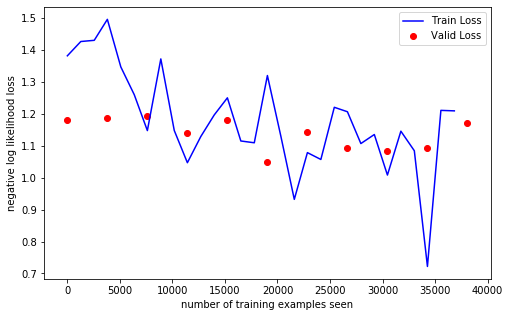

In [55]:
# Fix it to say Valid Loss

fig = plt.figure(figsize=(8,5))
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(valid_counter, valid_losses, color='red')
plt.legend(['Train Loss', 'Valid Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

Judging from the training curve  it looks like we could even continue training for a few more epochs!


But before that let's again look at a few examples as we did earlier and compare the model's output.

In [0]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [57]:
# sample output

with torch.no_grad():
  output = network(example_data)

output[0]

RuntimeError: ignored

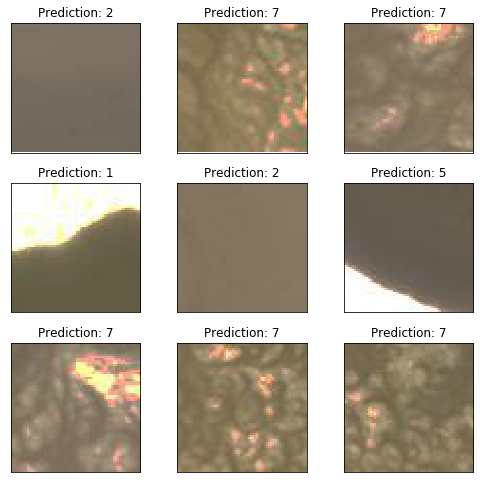

In [48]:
fig = plt.figure(figsize=(7,7))

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(disp_image(example_data[i]), interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])



## Continued Training from Checkpoints

Now let's continue training the network, or rather see how we can continue training from the state_dicts we saved during our first training run. We'll initialize a new set of network and optimizers.

In [0]:
continued_network = Net()
continued_optimizer = optim.Adam(network.parameters())

Using `.load_state_dict()` we can now load the internal state of the network and optimizer when we last saved them.

In [0]:
network_state_dict = torch.load('/results/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('/results/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

Again running a training loop should immediately pick up the training where we left it. To check on that let's simply use the same lists as before to keep track of the loss values. Due to the way we constructed the test counter for the number of training examples seen we manually have to append to it here.

In [29]:
# change the range to 11,20 for next run..
for i in range(11,50):
  valid_counter.append(i*len(train_loader.dataset))
  train(i)
  valid()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 11 [0/16395 (0%)]	Loss: 1.223330
Train Epoch: 11 [3200/16395 (19%)]	Loss: 1.257095
Train Epoch: 11 [6400/16395 (39%)]	Loss: 0.954348
Train Epoch: 11 [9600/16395 (58%)]	Loss: 1.228190
Train Epoch: 11 [12800/16395 (78%)]	Loss: 0.899025
Train Epoch: 11 [16000/16395 (97%)]	Loss: 0.847650
\Vaild set: Avg. loss: 1.3491, Accuracy: 2162/4103 (53%)

Train Epoch: 12 [0/16395 (0%)]	Loss: 0.999806
Train Epoch: 12 [3200/16395 (19%)]	Loss: 0.988622
Train Epoch: 12 [6400/16395 (39%)]	Loss: 1.047933
Train Epoch: 12 [9600/16395 (58%)]	Loss: 0.924917
Train Epoch: 12 [12800/16395 (78%)]	Loss: 0.893755
Train Epoch: 12 [16000/16395 (97%)]	Loss: 1.205882
\Vaild set: Avg. loss: 1.0331, Accuracy: 2368/4103 (58%)

Train Epoch: 13 [0/16395 (0%)]	Loss: 0.885180
Train Epoch: 13 [3200/16395 (19%)]	Loss: 1.026842
Train Epoch: 13 [6400/16395 (39%)]	Loss: 0.999982
Train Epoch: 13 [9600/16395 (58%)]	Loss: 1.242347
Train Epoch: 13 [12800/16395 (78%)]	Loss: 1.445485
Train Epoch: 13 [16000/16395 (97%)]	Loss:

Great! We again see a (much slower) increase in test set accuracy from epoch to epoch. Let's visualize this to further inspect the training progress.

Text(0, 0.5, 'negative log likelihood loss')

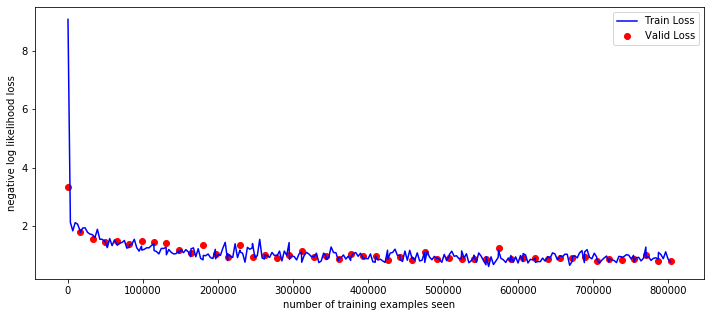

In [30]:
fig = plt.figure(figsize=(12,5))
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(valid_counter, valid_losses, color='red')
plt.legend(['Train Loss', 'Valid Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

That still looks like a rather smooth learning curve just as if we initially would've trained for 8 epochs! Remember that we just appended values to the same lists starting from the 5th red dot onward.

From this we can conclue two things:

1. Continuing from the checkpointed internal state worked as intended.

2. We still don't seem to run into overfitting issues! It looks like our dropout layers did a good job regularizing the model.

In summary we built a new environment with PyTorch and TorchVision, used it to classifiy handwritten digits from the MNIST dataset and hopefully developed a good intuition using PyTorch. For further information the official PyTorch documentation is really nicely written and the forums are also quite active!

## Confusion Matrix

In [32]:
network.eval()

with torch.no_grad():
  for data, target in test_loader:
    output = network(data)
    pred = output.data.max(1, keepdim=True)[1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
pred = pred.numpy().reshape(-1)

In [34]:
pred.shape

(3655,)

In [0]:
target = target.numpy()

In [0]:
from pandas import DataFrame as df
from sklearn.metrics import confusion_matrix

In [0]:
cm = confusion_matrix(target, pred)

In [0]:
vals = [i+1 for i in range(8)]

In [39]:
df2 = df(cm, vals, vals)
df2

,1,2,3,4,5,6,7,8
1,0,80,0,0,0,75,0,0
2,0,84,0,0,0,177,0,0
3,0,10,948,0,0,3,0,2
4,0,0,469,0,0,2,0,0
5,0,58,42,0,0,41,0,0
6,0,7,88,0,0,110,0,0
7,3,15,14,0,0,20,26,5
8,0,13,0,0,0,0,8,1355


In [0]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score

In [41]:
# added balanced accuracy score in evaluation
balanced_accuracy_score(target, pred)

0.3926049383083882

In [42]:
accuracy_score(target, pred)

0.6902872777017783

In [0]:
def value_counts(x):
  unique, counts = np.unique(x, return_counts=True)
  print(np.asarray((unique, counts)).T)

In [44]:
value_counts(target)

[[   0  155]
 [   1  261]
 [   2  963]
 [   3  471]
 [   4  141]
 [   5  205]
 [   6   83]
 [   7 1376]]


In [45]:
value_counts(pred)

[[   0    3]
 [   1  267]
 [   2 1561]
 [   5  428]
 [   6   34]
 [   7 1362]]


## Visualise Activations & GradCAM

In [0]:
# from torch.utils.tensorboard import SummaryWriter
# import numpy as np

# writer = SummaryWriter()

# writer.add_pr_curve('pr_curve', target, pred, 0)
# writer.close()

In [0]:
# ! zip -r -X runs.zip runs

  adding: runs/ (stored 0%)
  adding: runs/Nov24_07-48-13_6abaa22567ef/ (stored 0%)
  adding: runs/Nov24_07-48-13_6abaa22567ef/events.out.tfevents.1574581693.6abaa22567ef.123.5 (deflated 5%)


In [0]:
# https://pytorch.org/docs/stable/tensorboard.html
# %load_ext tensorboard
# %tensorboard --logdir "$runs"

In [0]:
# http://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html
# https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/gradcam.py



In [0]:
# https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html